# Background

In [289]:
#!pip install yfinance

In [290]:
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import requests
import numpy as np
import pandas as pd
import yfinance as yf

In [291]:
def Risk_Free_Rate(Risk_Free):
  Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
  Risk_Free = Risk_Free.reset_index()
  Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
  Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
  Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
  Risk_Free = Risk_Free.dropna()
  Risk_Free = Risk_Free[["Date", "TB", "Risk-Free Return"]]
  return Risk_Free

In [292]:
"""
def rolling_intercept(x, y, window_size):
    intercepts = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        intercepts.append(intercept)

    return intercepts
"""

'\ndef rolling_intercept(x, y, window_size):\n    intercepts = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the intercept using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n        intercepts.append(intercept)\n\n    return intercepts\n'

In [293]:
"""
def rolling_slope(x, y, window_size):
    slopes = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)

    return slopes
"""

'\ndef rolling_slope(x, y, window_size):\n    slopes = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the slope using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n        slopes.append(slope)\n\n    return slopes\n'

In [294]:
"""
#Creat a function to calucalte stock/market return caompare value with previuos one
def Return_Rate(x,y,z):
  x = x.rename(columns = {"Adj Close": y})
  x["Date"] = pd.to_datetime(x["Date"])
  x[y] = pd.to_numeric(x[y])
  x["REF"] = x[y].shift(periods=1)
  x[z] = (x[y]-x["REF"])/x["REF"]
  x = x.dropna()
  x = x[["Index", "Date",y,"REF", z]]
  return x
"""

'\n#Creat a function to calucalte stock/market return caompare value with previuos one\ndef Return_Rate(x,y,z):\n  x = x.rename(columns = {"Adj Close": y})\n  x["Date"] = pd.to_datetime(x["Date"])\n  x[y] = pd.to_numeric(x[y])\n  x["REF"] = x[y].shift(periods=1)\n  x[z] = (x[y]-x["REF"])/x["REF"]\n  x = x.dropna()\n  x = x[["Index", "Date",y,"REF", z]]\n  return x\n'

In [295]:
"""
import numpy as np
from scipy.stats import ttest_rel
import pandas as pd

def rolling_intercept(x, y, window_size):
    intercepts = []
    intercept_p_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        intercepts.append(intercept)

    # Perform t-test for the intercept
    t_stat, p_value = ttest_rel(intercepts, np.zeros_like(intercepts))
    intercept_p_values = [p_value] * len(intercepts)

    return intercepts, intercept_p_values

def rolling_slope(x, y, window_size):
    slopes = []
    slope_p_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)

    # Perform t-test for the slope
    t_stat, p_value = ttest_rel(slopes, np.zeros_like(slopes))
    slope_p_values = [p_value] * len(slopes)

    return slopes, slope_p_values
"""

'\nimport numpy as np\nfrom scipy.stats import ttest_rel\nimport pandas as pd\n\ndef rolling_intercept(x, y, window_size):\n    intercepts = []\n    intercept_p_values = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the intercept using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n        intercepts.append(intercept)\n\n    # Perform t-test for the intercept\n    t_stat, p_value = ttest_rel(intercepts, np.zeros_like(intercepts))\n    intercept_p_values = [p_value] * len(intercepts)\n\n    return intercepts, intercept_p_values\n\ndef rolling_slope(x, y, window_size):\n    slopes = []\n    slope_p_values = []\n\n    for i in range(len(x) - window_size + 1):\n        x_window = x[i:i+window_size]\n        y_window = y[i:i+window_size]\n\n        # Calculate the slope using numpy polyfit\n        slope, intercept = np.polyfit(x_window, y_window, 1)\n    

# Type in Date and Trade Name

In [296]:
#History Data Time Frame
Startdate = "2004-4-1"
Enddate = "2024-04-10"

Startdate = pd.to_datetime(Startdate)
Enddate = pd.to_datetime(Enddate)

Beta_year = 5
B = Beta_year*12
B = int(B)
print(B)

Trade_Name = "XOM"

Stock = yf.download(Trade_Name, interval='1mo')
Stock.insert(0, "Index", range(1, 1 + len(Stock)))
Stock = Stock.reset_index(drop=False)

[*********************100%%**********************]  1 of 1 completed

60


In [297]:
print(Stock.Date[0].strftime("%Y-%m"))
print(Stock.Date.iloc[-1].strftime("%Y-%m"))

1985-01
2024-05


In [298]:
assert Stock.Date[0] + relativedelta(years=Beta_year) < Startdate

In [299]:
from dateutil.relativedelta import relativedelta
# Calculate the difference in months
difference = relativedelta(Stock.Date.iloc[-1], Stock.Date.iloc[0])
total_months = difference.years * 12 + difference.months

assert total_months > B

# Basic Data

In [300]:
Startdate = pd.to_datetime(Startdate) - relativedelta(years=Beta_year)
Enddate = pd.to_datetime(Enddate)

In [301]:
#Risk-Free rate taken as Treasury bond from Yahoo Finance: 13 Week Treasury Bill: ^IRX, 	Treasury Yield 5 Years: ^FVX, Treasury Yield 10 Years: ^TNX, Treasury Yield 30 Years: ^TYX
TB13W = yf.download("^IRX",start=Startdate,end=Enddate, interval='1mo')
TB5 = yf.download("^FVX",start=Startdate,end=Enddate, interval='1mo')
TB10 = yf.download("^TNX",start=Startdate,end=Enddate, interval='1mo')
TB30 = yf.download("^TYX",start=Startdate,end=Enddate, interval='1mo')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [302]:
Risk_Free = TB13W
Risk_Free = Risk_Free.reset_index(drop=False)

Risk_Free.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
298,2024-02-01,5.195,5.253,5.188,5.223,5.223,0
299,2024-03-01,5.218,5.245,5.178,5.203,5.203,0
300,2024-04-01,5.205,5.255,5.165,5.245,5.245,0


In [303]:
Risk_Free.iloc[:, 1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,1.798495,1.899319,1.681399,1.795186,1.795186,2.332425e+04
std,1.919000,1.959957,1.865820,1.922208,1.922208,2.129063e+05
min,0.003000,0.015000,-0.235000,0.003000,0.003000,0.000000e+00
25%,0.090000,0.120000,0.055000,0.090000,0.090000,0.000000e+00
50%,1.097000,1.197000,1.000000,1.101000,1.101000,0.000000e+00
75%,3.280000,3.460000,2.882000,3.280000,3.280000,0.000000e+00
max,6.170000,6.230000,6.000000,6.150000,6.150000,2.959200e+06


In [304]:
SP_500 = yf.download("^GSPC",start=Startdate,end=Enddate, interval='1mo')
#SP_500 = yf.download("SPY",start=Startdate,end=Enddate, interval='1mo')
NASDAQ = yf.download("^IXIC",start=Startdate,end=Enddate, interval='1mo')
VTI = yf.download("VTI",start=Startdate,end=Enddate, interval='1mo')
Dow_Jones = yf.download("^DJI",start=Startdate,end=Enddate, interval='1mo')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [305]:
#Market Return based on S&P500 Index data from Yahoo Finance
Market = SP_500
Market = Market.reset_index(drop=False)

Market.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
298,2024-02-01,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000
299,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000
300,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000


In [306]:
Market.iloc[:, 1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,1988.426109,2055.788042,1917.842691,1999.471659,1999.471659,6.835137e+10
std,1096.476167,1135.448461,1060.707723,1107.694582,1107.694582,3.013985e+10
min,729.570007,832.979980,666.789978,735.090027,735.090027,1.533293e+10
25%,1207.010010,1239.780029,1165.540039,1207.010010,1207.010010,4.203009e+10
50%,1437.900024,1488.930054,1398.109985,1440.670044,1440.670044,7.341696e+10
75%,2583.209961,2708.949951,2447.489990,2640.870117,2640.870117,8.597863e+10
max,5257.970215,5264.850098,5056.819824,5254.350098,5254.350098,1.621854e+11


In [307]:
Stock = yf.download(Trade_Name,start = Startdate, end = Enddate, interval='1mo')
Stock = Stock.reset_index(drop=False)

[*********************100%%**********************]  1 of 1 completed


In [308]:
Stock.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-04-01,35.15625,42.62500,34.71875,41.53125,19.132660,196539400
1,1999-05-01,41.50000,43.62500,38.78125,39.93750,18.398457,180442400
2,1999-06-01,39.81250,41.71875,37.43750,38.56250,17.853277,156534200


In [309]:
Stock.iloc[:,1:].describe()

,Open,High,Low,Close,Adj Close,Volume
count,301.000000,301.000000,301.000000,301.000000,301.000000,3.010000e+02
mean,69.765154,73.131312,66.505000,69.973920,47.212346,3.702562e+08
std,21.783622,22.377249,21.013216,21.906312,22.650849,1.779434e+08
min,32.180000,35.090000,29.750000,31.900000,15.874788,1.496624e+08
25%,46.200001,51.080002,44.200001,46.470001,30.231489,2.394018e+08
50%,74.150002,77.370003,69.209999,74.349998,48.216290,3.158961e+08
75%,86.470001,89.300003,82.830002,86.339996,58.336380,4.462582e+08
max,117.529999,123.750000,115.379997,118.339996,118.269997,1.384259e+09


# Return Rate

In [310]:
#Calcuate risk free return for each month
Risk_Free = Risk_Free.rename(columns = {"Adj Close":"TB"})
Risk_Free["Date"] = pd.to_datetime(Risk_Free["Date"])
Risk_Free["TB"] = pd.to_numeric(Risk_Free["TB"])
#Risk_Free["Risk-Free Return"] = Risk_Free["TB"]/100
#Risk_Free["Risk-Free Return"] = ((1+Risk_Free["Risk-Free Return"])**(1/12))-1

#Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: ((1 + x / 100) ** (1/12)) - 1)
Risk_Free["Risk-Free Return"] = Risk_Free["TB"].apply(lambda x: (x/12)/100)


Risk_Free = Risk_Free.dropna()

"""
first_value = Risk_Free["Risk-Free Return"].iloc[0]
Risk_Free["Risk-Free Return"] = first_value
"""

Risk_Free = Risk_Free[["Date", "TB", "Risk-Free Return"]]

Risk_Free.tail(10)

,Date,TB,Risk-Free Return
291,2023-07-01,5.248,0.004373
292,2023-08-01,5.298,0.004415
293,2023-09-01,5.300,0.004417
294,2023-10-01,5.320,0.004433
295,2023-11-01,5.238,0.004365
296,2023-12-01,5.180,0.004317
297,2024-01-01,5.188,0.004323
298,2024-02-01,5.223,0.004353
299,2024-03-01,5.203,0.004336
300,2024-04-01,5.245,0.004371


In [311]:
#Creat a function to calucalte stock/market return caompare value with previuos one

def Return_Rate(x, y, z):
    x = x.rename(columns={"Adj Close": y})
    x["Date"] = pd.to_datetime(x["Date"])
    x[y] = pd.to_numeric(x[y])
    x[y + "_Prev"] = x[y].shift(periods=1)
    x[z] = x[y].pct_change()
    x = x.dropna()

    return x

In [312]:
Stock = Return_Rate(Stock, "Stock Value", "Stock Return")

Market = Return_Rate(Market, "Market Value", "Market Return")

In [313]:
Stock.tail(10)

,Date,Open,High,Low,Close,Stock Value,Volume,Stock Value_Prev,Stock Return
291,2023-07-01,107.489998,108.459999,100.220001,107.239998,104.433640,350338600,104.443375,-0.000093
292,2023-08-01,106.949997,112.070000,104.570000,111.190002,108.280266,315896100,104.433640,0.036833
293,2023-09-01,112.199997,120.699997,112.199997,117.580002,115.441681,320550000,108.280266,0.066138
294,2023-10-01,117.529999,117.790001,104.540001,105.849998,103.924995,493930700,115.441681,-0.099762
295,2023-11-01,106.529999,109.190002,101.150002,102.739998,100.871559,433367400,103.924995,-0.029381
296,2023-12-01,102.500000,104.220001,97.480003,99.980003,99.059380,453909500,100.871559,-0.017965
297,2024-01-01,100.919998,104.879997,95.769997,102.809998,101.863312,413171900,99.059380,0.028306
298,2024-02-01,103.570000,105.430000,100.419998,104.519997,103.557571,360899900,101.863312,0.016633
299,2024-03-01,105.720001,116.449997,104.029999,116.239998,116.239998,353938800,103.557571,0.122467
300,2024-04-01,116.410004,123.750000,115.379997,118.269997,118.269997,385135700,116.239998,0.017464


In [314]:
Market.tail(10)

,Date,Open,High,Low,Close,Market Value,Volume,Market Value_Prev,Market Return
291,2023-07-01,4450.479980,4607.069824,4385.049805,4588.959961,4588.959961,75063200000,4450.379883,0.031139
292,2023-08-01,4578.830078,4584.620117,4335.310059,4507.660156,4507.660156,86840820000,4588.959961,-0.017716
293,2023-09-01,4530.600098,4541.250000,4238.629883,4288.049805,4288.049805,73482980000,4507.660156,-0.048719
294,2023-10-01,4284.520020,4393.569824,4103.779785,4193.799805,4193.799805,83519460000,4288.049805,-0.021980
295,2023-11-01,4201.270020,4587.640137,4197.740234,4567.799805,4567.799805,80970570000,4193.799805,0.089179
296,2023-12-01,4559.430176,4793.299805,4546.500000,4769.830078,4769.830078,81530670000,4567.799805,0.044229
297,2024-01-01,4745.200195,4931.089844,4682.109863,4845.649902,4845.649902,81737880000,4769.830078,0.015896
298,2024-02-01,4861.109863,5111.060059,4853.520020,5096.270020,5096.270020,82066930000,4845.649902,0.051721
299,2024-03-01,5098.509766,5264.850098,5056.819824,5254.350098,5254.350098,86299510000,5096.270020,0.031019
300,2024-04-01,5257.970215,5263.950195,4953.560059,5035.689941,5035.689941,81747170000,5254.350098,-0.041615


In [315]:
Market['Market Return'].tail(60).mean()*12

0.12455435361546141

# Premium

In [316]:
# Create a function to calculate the market/stock premium
# by taking the market/stock return and subtracting the risk free return
# Manipulating the data to fit our format by renaming columns
def Premium(x, y, z, a, b):
  x = pd.merge(y, Risk_Free, on = "Date")
  x[z] = x[a] - x["Risk-Free Return"]
  x = x[["Date", "Risk-Free Return", z, b]]
  x = x.rename(columns = {"Date_y":"Date"})
  return x

In [317]:
#Run function to get Market/Stock Premium
Market_Premium = Premium('Market_Premium', Market, 'Market Premium', 'Market Return', 'Market Return')

Stock_Premium = Premium('Stock_Premium', Stock, 'Stock Premium', 'Stock Return', 'Stock Return')

In [318]:
Market_Premium.tail(5)

,Date,Risk-Free Return,Market Premium,Market Return
295,2023-12-01,0.004317,0.039913,0.044229
296,2024-01-01,0.004323,0.011572,0.015896
297,2024-02-01,0.004353,0.047368,0.051721
298,2024-03-01,0.004336,0.026683,0.031019
299,2024-04-01,0.004371,-0.045986,-0.041615


In [319]:
Market_Premium.tail(12).mean()

Date                2023-10-16 08:00:00
Risk-Free Return               0.004364
Market Premium                 0.012333
Market Return                  0.016697
dtype: object

In [320]:
Stock_Premium.head(5)

,Date,Risk-Free Return,Stock Premium,Stock Return
0,1999-05-01,0.003758,-0.042133,-0.038374
1,1999-06-01,0.003892,-0.033523,-0.029632
2,1999-07-01,0.003850,0.025323,0.029173
3,1999-08-01,0.004042,-0.010341,-0.006300
4,1999-09-01,0.003925,-0.035484,-0.031559


# Beta and Cost of Equity Calculation

In [321]:
import numpy as np
from scipy.stats import ttest_1samp
import pandas as pd

def rolling_intercept_and_r_squared(x, y, window_size):
    intercepts = []
    intercept_p_values = []
    r_squared_values = []
    r_squared_adj_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the intercept using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        intercepts.append(intercept)

        # Calculate the R-squared value
        y_predicted = np.polyval([slope, intercept], x_window)
        residuals = y_window - y_predicted
        SSR = np.sum(residuals**2)
        SST = np.sum((y_window - np.mean(y_window))**2)
        r_squared = 1 - SSR / SST
        r_squared_values.append(r_squared)

        # Calculate the adjusted R-squared value
        n = len(y_window)
        k = 2  # Assuming two predictors (Market Premium and Stock Premium)
        r_squared_adj = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
        r_squared_adj_values.append(r_squared_adj)

        # Perform t-test for the intercept
        t_stat, p_value = ttest_1samp(intercepts, 0)
        intercept_p_values.append(p_value)

    return intercepts, intercept_p_values, r_squared_values, r_squared_adj_values

def rolling_slope_and_r_squared(x, y, window_size):
    slopes = []
    slope_p_values = []
    r_squared_values = []
    r_squared_adj_values = []

    for i in range(len(x) - window_size + 1):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        # Calculate the slope using numpy polyfit
        slope, intercept = np.polyfit(x_window, y_window, 1)
        slopes.append(slope)

        # Calculate the R-squared value
        y_predicted = np.polyval([slope, intercept], x_window)
        residuals = y_window - y_predicted
        SSR = np.sum(residuals**2)
        SST = np.sum((y_window - np.mean(y_window))**2)
        r_squared = 1 - SSR / SST
        r_squared_values.append(r_squared)

        # Calculate the adjusted R-squared value
        n = len(y_window)
        k = 2  # Assuming two predictors (Market Premium and Stock Premium)
        r_squared_adj = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
        r_squared_adj_values.append(r_squared_adj)

        # Perform t-test for the slope
        t_stat, p_value = ttest_1samp(slopes, 0)
        slope_p_values.append(p_value)

    return slopes, slope_p_values, r_squared_values, r_squared_adj_values

def Cost_of_Equity(x, y, z):
    x = pd.merge(y, z, on="Date")
    x = x.dropna()

    intercepts, intercept_p_values, r_squared_values, r_squared_adj_values = rolling_intercept_and_r_squared(
        x["Market Premium"], x["Stock Premium"], B
    )
    slopes, slope_p_values, _, _ = rolling_slope_and_r_squared(
        x["Market Premium"], x["Stock Premium"], B
    )

    x = x.iloc[B - 1:]

    x = x.dropna()



    x["Market Compound Rate_0"] = (1 + x["Market Return"])
    x["Market Investment"] = x["Market Compound Rate_0"].cumprod() * 1000

    x["Stock Compound Rate_0"] = (1 + x["Stock Return"])
    x["Stock Investment"] = x["Stock Compound Rate_0"].cumprod() * 1000

    x["Alpha"] = intercepts
    x["Beta"] = slopes
    x = x.rename(columns={"Risk-Free Return_x": "Risk-Free Return"})
    x = x.dropna()

    x["Cost of Equity"] = x["Risk-Free Return"] + x["Beta"] * (x["Market Premium"])
    x = x[["Date", "Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity"]]

    # Append p-values, R-squared, and adjusted R-squared values to the DataFrame
    x["Alpha_p_value"] = intercept_p_values
    x["Beta_p_value"] = slope_p_values
    x["R-squared"] = r_squared_values
    x["R-squared_adj"] = r_squared_adj_values

    # Round specific columns to 2 decimal places
    columns_to_round = ["Risk-Free Return", "Market Investment", "Stock Investment", "Alpha", "Beta", "Cost of Equity",
                        "Alpha_p_value", "Beta_p_value", "R-squared", "R-squared_adj"]
    x[columns_to_round] = x[columns_to_round].round(3)

    return x


# Cost of Equity result

In [322]:
COE = Cost_of_Equity("COE", Market_Premium, Stock_Premium)
COE.tail()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Date,Risk-Free Return,Market Investment,Stock Investment,Alpha,Beta,Cost of Equity,Alpha_p_value,Beta_p_value,R-squared,R-squared_adj
295,2023-12-01,0.004,4235.294,4596.320,0.004,0.953,0.042,0.123,0.0,0.259,0.233
296,2024-01-01,0.004,4302.617,4726.421,0.004,0.955,0.015,0.116,0.0,0.254,0.228
297,2024-02-01,0.004,4525.151,4805.034,0.003,0.942,0.049,0.111,0.0,0.250,0.224
298,2024-03-01,0.004,4665.516,5393.495,0.004,0.950,0.030,0.104,0.0,0.251,0.225
299,2024-04-01,0.004,4471.360,5487.686,0.006,0.941,-0.039,0.095,0.0,0.250,0.223


In [323]:
Beta = COE["Beta"].tail(1).round(2)
Market_Mean = Market["Market Return"].tail(60).mean() * 12
equity = COE["Cost of Equity"].tail(60).mean()
annual_equity = equity * 12
alpha = COE["Alpha"].tail(12).mean()
annualized_alpha = alpha * 12

# Corrected print statement for Beta
print(f"Beta is {Beta.iloc[0]}")
print(f"Annualized Market Return is {Market_Mean:.2%}")
print(f"Average Monthly Cost of Equity is {equity:.2%}")
print(f"Annualized Cost of Equity is {annual_equity:.2%}")
print(f"Average Monthly Alpha is {alpha:.2%}")
print(f"Annualized Alpha is {annualized_alpha:.2%}")


Beta is 0.94
Annualized Market Return is 12.46%
Average Monthly Cost of Equity is 1.33%
Annualized Cost of Equity is 15.90%
Average Monthly Alpha is 0.44%
Annualized Alpha is 5.30%


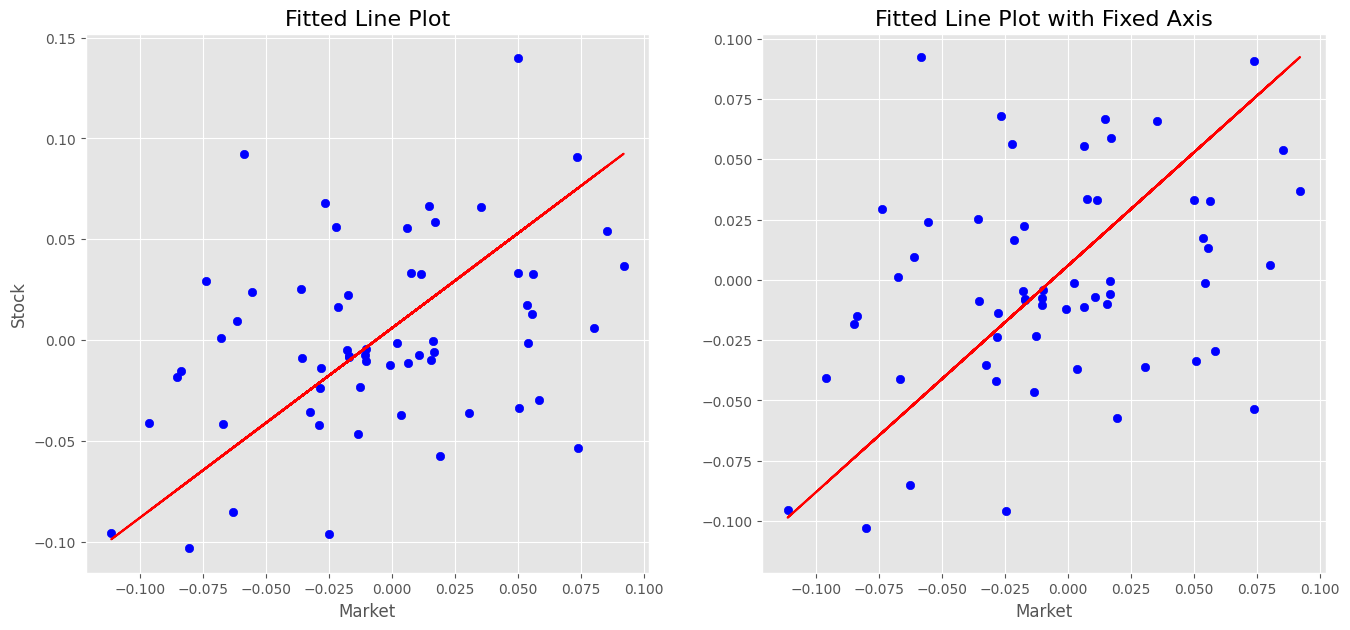

In [324]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(16, 7)

axes[0].scatter(Market_Premium["Market Premium"][:60], Stock_Premium["Stock Premium"][:60], color = 'blue')
axes[0].plot(Market_Premium["Market Premium"][:60],Market_Premium["Market Premium"][:60] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes[0].set(title = "Fitted Line Plot", xlabel = "Market", ylabel = "Stock")
axes[0].title.set_size(16)

axes[1].scatter(Market_Premium["Market Premium"][:60], Stock_Premium["Stock Premium"][:60], color = 'blue')
axes[1].plot(Market_Premium["Market Premium"][:60],Market_Premium["Market Premium"][:60] * Beta.values + COE['Alpha'].tail(1).values, color = 'red')
axes[1].set(title = "Fitted Line Plot with Fixed Axis", xlabel = "Market")
axes[1].title.set_size(16)


# Get default xlim values
default_xlim = axes[0].get_xlim()
default_ylim = axes[0].get_ylim()

# Set ylim using default xlim values and their negative counterparts
axes[1].set_ylim(default_xlim[0], default_xlim[1])
#axes.set_xlim(default_ylim[0], default_ylim[1])

plt.show()

# Trend line

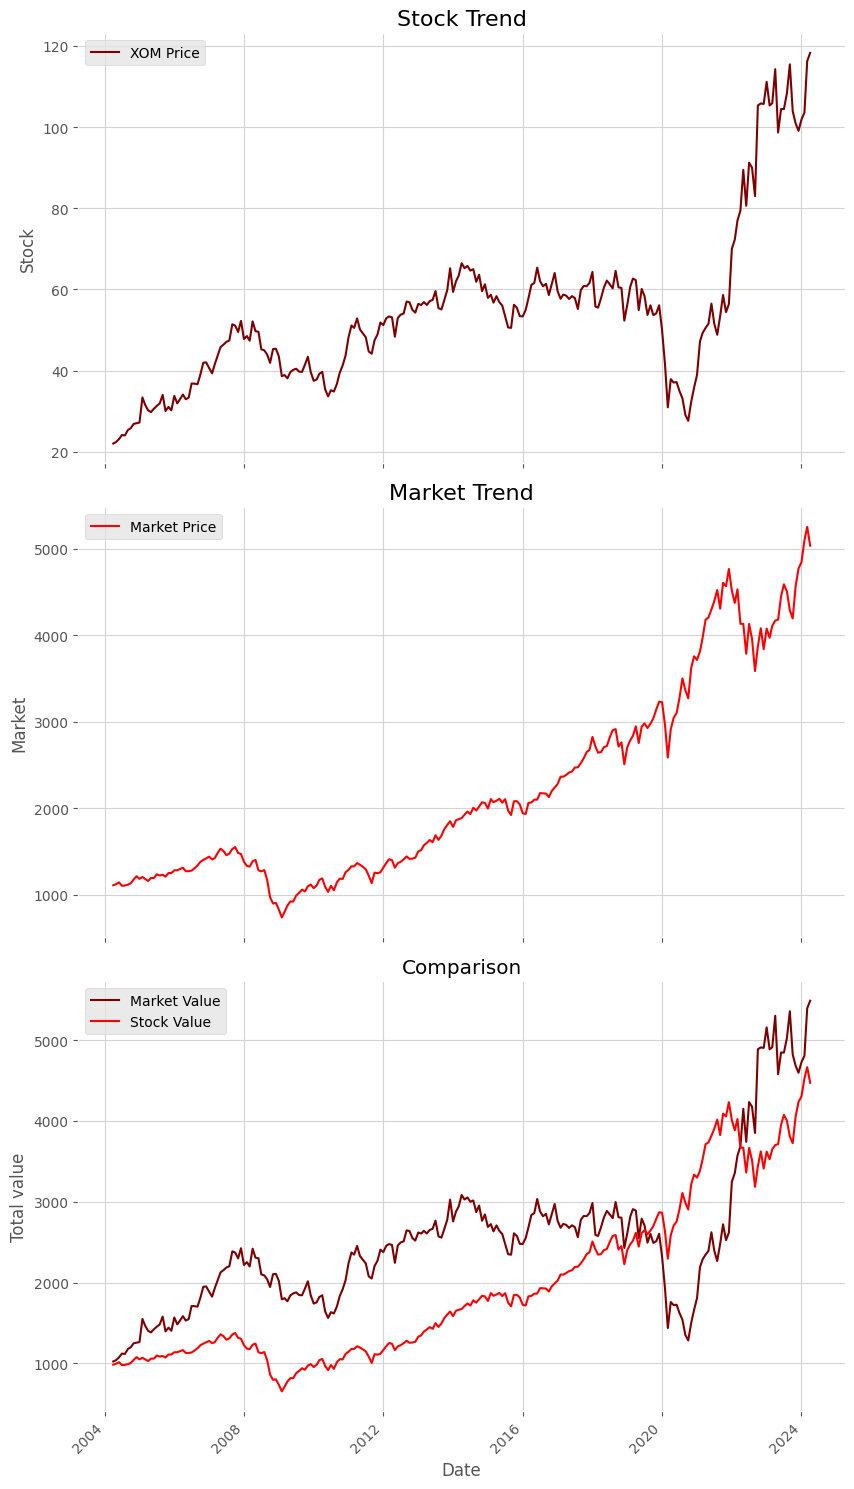

In [325]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)
Max_Stock = Stock["Stock Value"].abs().max()*1.05
Max_Market = Market["Market Value"].abs().max()*1.05
max_abs_value = max(Max_Stock.max(), Max_Market.max()) * 1.05
max_abs_value_investment = max((COE["Market Investment"].max()), (COE["Stock Investment"].max())) * 1.05
axes[0].plot(Stock["Date"][B-1:], Stock["Stock Value"][B-1:],color="maroon")
axes[0].set(title = "Stock Trend", xlabel = "Date", ylabel = "Stock")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(Market["Date"][B-1:], Market["Market Value"][B-1:],color = "red")
axes[1].set(title = "Market Trend", xlabel = "Date", ylabel = "Market")
axes[2].plot(COE["Date"], COE["Stock Investment"], color = "maroon")
axes[2].plot(COE["Date"], COE["Market Investment"], color = "red")


axes[2].set(title = "Comparison", xlabel = "Date", ylabel = "Total value")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)
"""
axes[0].set_ylim([0,Max_Stock])
axes[1].set_ylim([0,Max_Market])
axes[2].set_ylim([0,max_abs_value_investment])
"""

for i in range(0,3):
  axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([Trade_Name +" Price"] ,loc = 2) #move legend to right
axes[1].legend(["Market Price"] ,loc = 2)
axes[2].legend([ "Market Value", "Stock Value",] ,loc = 2)
fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()

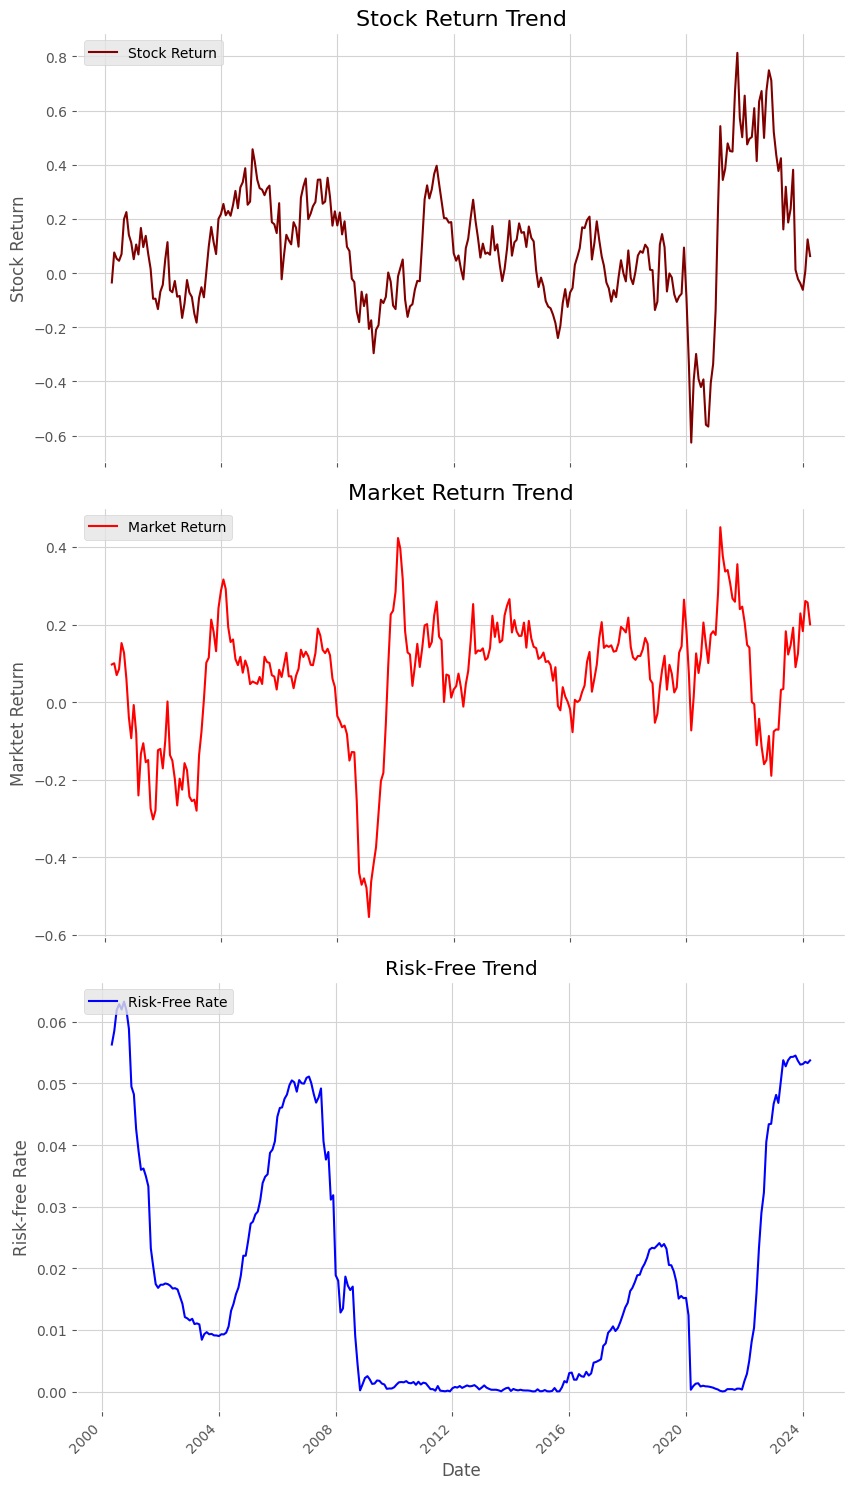

In [326]:
fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 15)

#Moving_average_Stock = Stock["Stock Return"].rolling(12).mean()*12
#Moving_average_Market = Market["Market Return"].rolling(12).mean()*12

Moving = 12

axes[0].plot(Stock["Date"], Stock["Stock Return"].rolling(Moving).mean()*12, color = "maroon")
axes[0].set(title = "Stock Return Trend", xlabel = "Date", ylabel = "Stock Return")
axes[0].title.set_size(16)
#plt.grid(color = "lightgray")
axes[1].plot(Market["Date"], Market["Market Return"].rolling(Moving).mean()*12, color = "red")
axes[1].set(title = "Market Return Trend", xlabel = "Date", ylabel = "Marktet Return")
axes[2].plot(Risk_Free["Date"][Moving + 1:], (1+Risk_Free["Risk-Free Return"][Moving + 1:])**12-1, color = "blue")
axes[2].set(title = "Risk-Free Trend", xlabel = "Date", ylabel = "Risk-free Rate")
fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#max_abs_value = max(Stock["Stock Return"].abs().max(), Market["Market Return"].abs().max()) * 1.05
#axes[0].set_ylim([-max_abs_value, max_abs_value])
#axes[1].set_ylim([-max_abs_value, max_abs_value])
#axes[2].set_ylim([0, Risk_Free["Risk-Free Return"].abs().max()*12*1.05])

for i in range(0,3):
  axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([ "Stock Return"] ,loc = 2) #move legend to right
axes[1].legend([ "Market Return"] ,loc = 2)
axes[2].legend([ "Risk-Free Rate"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()

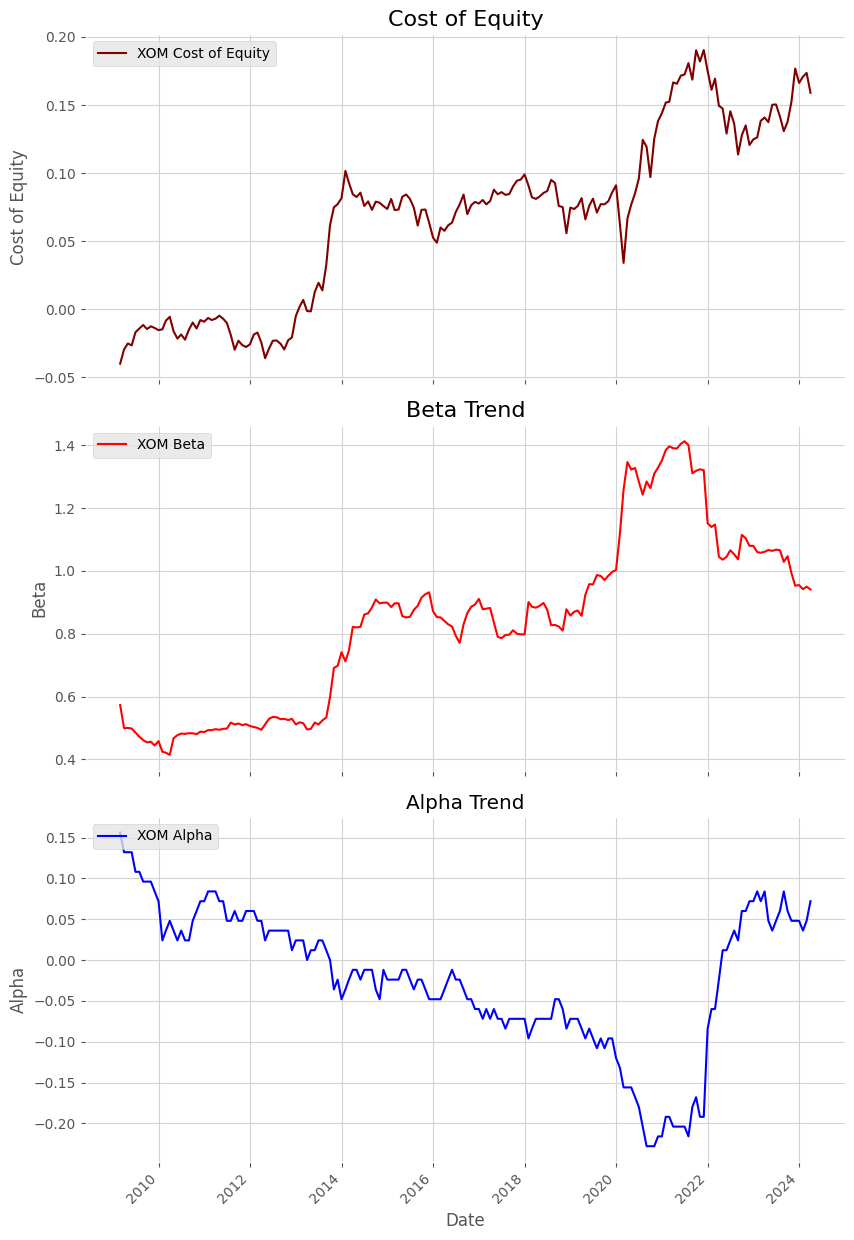

In [327]:
# Chart of cost of equity for each year for stock graphically

fig, axes = plt.subplots(nrows = 3, ncols = 1)
fig.set_size_inches(10, 12.5)

Moving = 60

axes[0].plot(COE["Date"], COE["Cost of Equity"].rolling(Moving).mean()*12, color = "maroon")
axes[0].set(title = "Cost of Equity", xlabel = "Date", ylabel = "Cost of Equity")
axes[0].title.set_size(16)
plt.grid(color = "lightgray")
axes[1].plot(COE["Date"][Moving-1:], COE["Beta"][Moving-1:], color = "red")
axes[1].set(title = "Beta Trend", xlabel = "Date", ylabel = "Beta")
axes[2].plot(COE["Date"][Moving-1:], COE["Alpha"][Moving-1:]*12, color = "blue")
axes[2].set(title = "Alpha Trend", xlabel = "Date", ylabel = "Alpha")

fig.autofmt_xdate(rotation=45) #format x-axis as date, rotate 45 degrees
axes[1].title.set_size(16)

#axes[0].set_ylim([-COE["Cost of Equity"].abs().max()*1.05*12,COE["Cost of Equity"].abs().max()*1.05*12])
#axes[1].set_ylim([COE["Beta"].min()-0.1,COE["Beta"].max()*1.05])
#axes[2].set_ylim([COE["Alpha"].min()-0.01*12,COE["Alpha"].max()*1.05*12])

for i in range(0,3):
  axes[i].set_facecolor('white') #make background behind grid white
  axes[i].grid(color = "lightgray")

axes[0].legend([Trade_Name +" Cost of Equity"] ,loc = 2) #move legend to right
axes[1].legend([Trade_Name +" Beta"] ,loc = 2)
axes[2].legend([Trade_Name +" Alpha"] ,loc = 2)

fig.tight_layout() #use tight layout
fig.subplots_adjust(right = .85) #adjust subplots to make legend fit, adjusted this a bit from smaller figure example!

plt.show()